# Auditory Sound Processing

    Author: Thomas Haslwanter
    Date: March 13, 2015
    Ver: 1.1

## Reading in Sound: WAV-files

In IPYNB-files I will be using "pylab inline", to make the content easier to read. This loads many *numpy* and *matplotlib.pyplot* functions into the current workspace, and activates interactive graphics.

In [1]:
%pylab inline
from scipy.io.wavfile import read

Populating the interactive namespace from numpy and matplotlib


In many programming languages there are tools to read in WAV-files ("Waveform Audio File Format"). An easy way to access most other sound-types is use the open source program [FFMPEG](http://ffmpeg.org) to convert other sound types to WAV.

WAV files have a strictly defined format:
<img src="Images/WAV-chunks.png">

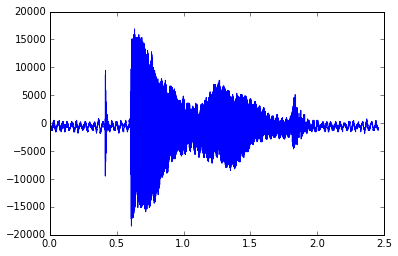

In [3]:
inFile = 'Sounds/a1.wav'

# You always have to read in the sample rate AND the data!
rate, data = read(inFile)

t = arange(len(data))/rate
plot(t, data)

<font color='red'>
<img src="Images/matlab_logo_s.jpg", width=50px, align='left'>*Matlab Equivalent Commands*:
</font>

    [data, rate] = audioread(inFile);



## Information about the sound

In [3]:
if len(data.shape)==1:
    print('Mono sound')
else:
    print('Stereo sound')

Mono sound


In [5]:
data.dtype

dtype('int16')

In [4]:
nData = len(data)
duration = nData/rate
print('Duration of recording: {0:4.2f} sec'.format(duration))

Duration of recording: 2.46 sec


<font color='red'>
*Matlab Equivalent Commands*:
</font>

    info = audioinfo(inFile);

#### Example of stereo sound

In [4]:
inFile = 'Sounds/tiger.wav'
rate, data = read(inFile)
data.shape

(230400, 2)

## Play Sound

In [6]:
from IPython.display import Audio, display

def play(x, fr, autoplay=False):
    display(Audio(x, rate=fr, autoplay=autoplay))

In [7]:
# back to a plain tone:
inFile = 'Sounds/a1.wav'
rate, data = read(inFile)
play(data, rate)

<font color='red'>
<img src="Images/matlab_logo_s.jpg", width=50px, align='left'>*Matlab Equivalent Commands*:
</font>

    player = audioplayer(data, rate);
    play(player);

## Fourier Transform & Power spectrum

(0, 5512.296368807949)

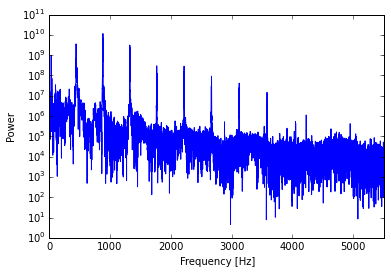

In [8]:
from scipy import fftpack

fftData = fftpack.fft(data)

# The conversion to real is because of numerical artefacts
Pxx = real(fftData * conj(fftData)) / nData
freq = arange(nData)/duration

semilogy(freq,Pxx)
xlabel('Frequency [Hz]')
ylabel('Power')
Nyquist = max(freq)/2
xlim(0, Nyquist)

### Symmetry of Powerspectrum
**Note:** for real inputs, the powerspectrum is always symmetrical!

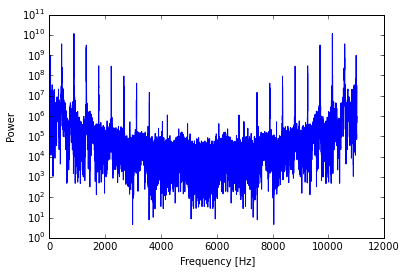

In [9]:
semilogy(freq, Pxx)
xlabel('Frequency [Hz]')
ylabel('Power')

#### Explanation
For real inputs f(t) we have the following relation:

$F(\omega) = F(-\omega)*$

In [10]:
%precision 2
print(fftData[1:3])  # second and third Fourier coefficients
print(fftData[:-3:-1]) # last two Fourier coefficients, with sequence reversed!

[-167240.92-894878.j   -837190.94+290807.52j]
[-167240.92+894878.j   -837190.94-290807.52j]


<img src="Images/ComplexNumber.jpg", width=300>

**Remember**

$fftData[0] \approx offset$

$fftData_{min}=\frac{1}{duration}$

$fftData_{max} = \frac{rate}{2} = Nyquist$

### Spectral density for practical applications: Welch-periodogram

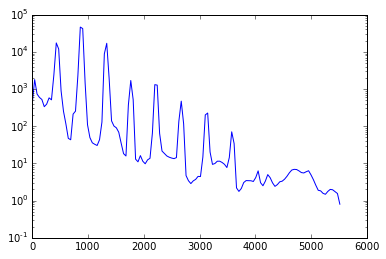

In [11]:
from scipy.signal import welch
f, Pxx = welch(data, rate)
semilogy(f, Pxx)

<font color='red'>
<img src="Images/matlab_logo_s.jpg", width=50px, align='left'>*Matlab Equivalent Commands*:
</font>

    [Pxx, f] = periodogram(data,[],[], rate);

## A Human Voice - Vowels

C:\WinPython-32bit-3.4.3.1\python-3.4.3\lib\site-packages\scipy\io\wavfile.py:42: WavFileWarning: Unknown wave file format
  warnings.warn("Unknown wave file format", WavFileWarning)


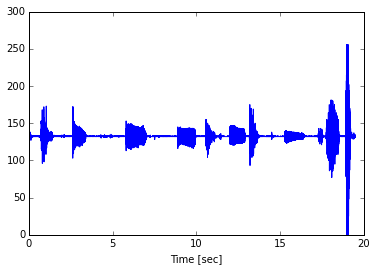

In [12]:
inFile = 'vowels.wav'

# The warning is caused by the data-type, which seems to be non-standard
rate, data = read(inFile)

t = arange(len(data))/rate
plot(t,data)
xlabel('Time [sec]')
play(data, rate)

In [44]:
data.dtype

dtype('uint8')

**Watch out with the datatype**, as overflow behavior is different from language to language!

In [45]:
data[0]

132

In [46]:
uint8(data[0]+200)

76

### Spectrogram

#### Detour: Shorter Timewindow -> wider Powerspectrum
Link to [Windowing](windowing.ipynb)

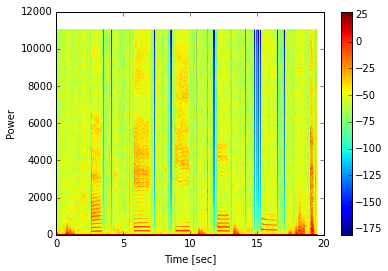

In [13]:
from matplotlib.pyplot import specgram
_ = specgram(data, NFFT=1024, Fs=rate)
xlabel('Time [sec]')
ylabel('Power')
colorbar()

Note the effect of the width of the sampling window:

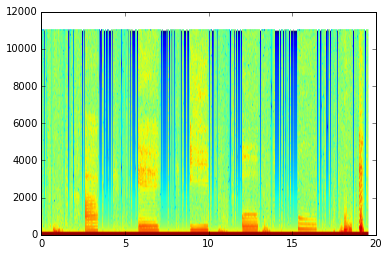

In [14]:
_ = specgram(data, NFFT=256, Fs=rate)

<font color='red'>
<img src="Images/matlab_logo_s.jpg", width=50px, align='left'>*Matlab Equivalent Commands*:
</font>

    spectrogram(data, 512, 450, 512, rate);

## Bandpass

A *bandpass* can be implemented in two ways:

* through an FFT, with selection of the corresponding components
* through an IIR-filter

<img src="Images/Simulation_CI.jpg" width=500>

## Linear Filters

### FIR-Filter: Feedforward
<img src="Images/MovingFilter.jpg" width=500>

### IIR-Filter: FIR + Feedback
<img src="Images/IIR_filter.jpg" width=500>

### Examples

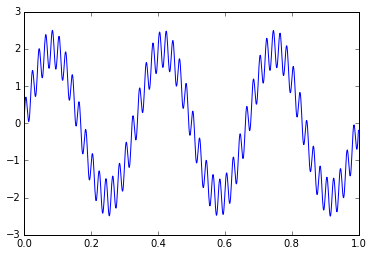

In [15]:
#Create a noisy data-set
rate = 1000
t = arange(0,1,1/rate)
freqs = [3, 50]
amps = [2, 0.5]
x = zeros(t.shape)
for freq, amp in zip(freqs,amps):
    x += amp * sin(2*pi*freq*t)
    
plot(t,x)

<font color='red'>
*Matlab Equivalent Commands*:
</font>


    Amplitudes = [2, 0.5];
    Frequencies = [3, 50]';
    Time = 0:1/rate:1;

    summed = Amplitudes * sin(2*pi*Frequencies*Time);


#### Example 1:  Lowpass

[ 1.   -3.84  5.52 -3.53  0.85]
[  8.98e-07   3.59e-06   5.39e-06   3.59e-06   8.98e-07]


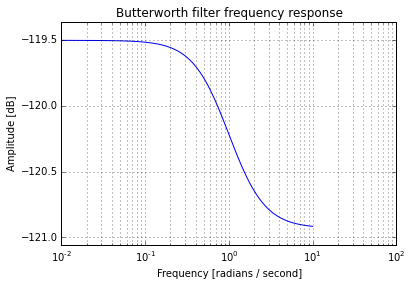

In [16]:
#Filter coefficients
from scipy import signal
Nyq = rate/2
b,a = signal.butter(4, 10/Nyq)

w, h = signal.freqs(b, a)
semilogx(w, 20 * log10(abs(h)))
title('Butterworth filter frequency response')
xlabel('Frequency [radians / second]')
ylabel('Amplitude [dB]')
margins(0, 0.1)
grid(which='both', axis='both')
axvline(100, color='green') # cutoff frequency
print(a)
print(b)

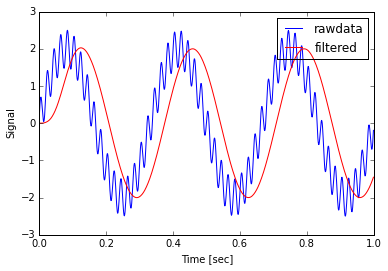

In [51]:
# Apply the filter to the noisy data
filtered = signal.lfilter(b,a,x)

plot(t,x, label='rawdata')
hold(True)
plot(t,filtered, 'r', label='filtered')
xlabel('Time [sec]')\

ylabel('Signal')
legend()

<font color='red'>
<img src="Images/matlab_logo_s.jpg", width=50px, align='left'>*Matlab Equivalent Commands*:
</font>

    filtered = filter(b,a,x);

#### Example 2: "filtfilt" - Lowpass, without delay

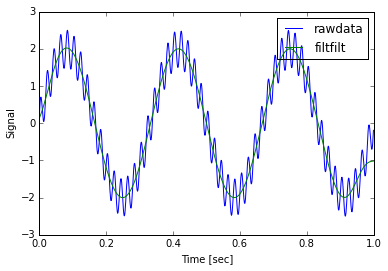

In [52]:
# For offline analysis, the delay can be eliminated through filtering once from the front, and once from the back
ffiltered = signal.filtfilt(b,a,x)

plot(t,x, label='rawdata')
hold(True)
plot(t,ffiltered, 'g', label='filtfilt')
xlabel('Time [sec]')\

ylabel('Signal')
legend()

#### Example 3: Bandpass

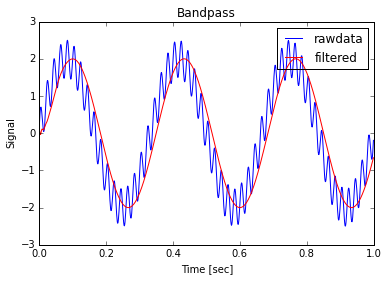

In [53]:
b,a = signal.butter(4, r_[20,100]/Nyq, 'bandstop')
filtered = signal.lfilter(b,a,x)

plot(t,x, label='rawdata')
hold(True)
plot(t,filtered, 'r', label='filtered')
xlabel('Time [sec]')
ylabel('Signal')
title('Bandpass')
legend()

## Further links to sound processing

* [FFMPEG](http://www.ffmpeg.org/) A complete, cross-platform solution to record, convert and stream audio and video. 
* [thLib.sounds](http://work.thaslwanter.at/thLib/html/sounds.html) My own implementation of reading/writing/playing sounds. Uses FFMPEG.
* [Pydub](http://pydub.com/) Lets you manipulate audio with a simple and easy high level interface. Requires FFMPEG.